In [1]:
using Gen
using Plots

## A generative model for linear regression

Meh.

In [2]:
@gen function model(xs::Vector{Float64})
    slope = @trace(normal(-1, exp(0.5)), :slope)
    intercept = @trace(normal(1, exp(2.0)), :intercept)
    for (i, x) in enumerate(xs)
        {:y=>i} ~ normal(slope * x + intercept, 1)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##model#292", Bool[0], false)

Observe some `ys` 

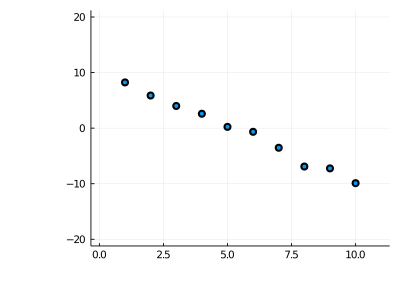

In [3]:
xs = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
ys = [8.23, 5.87, 3.99, 2.59, 0.23, -0.66, -3.53, -6.91, -7.24, -9.90]

observations = choicemap()
for (i, y) in enumerate(ys)
    observations[:y=>i] = y
end

scatter(xs, ys, xlims=[0, 11], ylims=[-20, 20], label=nothing, thickness_scaling=3.5, size=(1600, 1200))

## MAP optimization

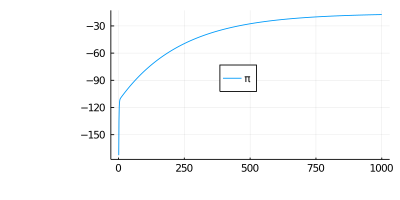

In [4]:
# initialize a random starting point
tr, _ = Gen.generate(model, (xs,), observations)
# an array to collect our log proto-posterior scores
πs = []
for i=1:1000
    # take a single gradient descent step with step size 1e-3 
    tr = map_optimize(tr, select(:slope, :intercept), max_step_size=1e-3, min_step_size=1e-3)
    # push the log score into array
    push!(πs, get_score(tr))
end
# visualize the log score 
plot(πs, labels="π", thickness_scaling=3.5, size=(1600, 800), legend=:inside)

In [5]:
get_choices(tr)

│
├── :intercept : 8.995462074818876
│
├── :slope : -1.8149797417446747
│
└── :y
    │
    ├── 5 : 0.23
    │
    ├── 4 : 2.59
    │
    ├── 6 : -0.66
    │
    ├── 7 : -3.53
    │
    ├── 2 : 5.87
    │
    ├── 10 : -9.9
    │
    ├── 9 : -7.24
    │
    ├── 8 : -6.91
    │
    ├── 3 : 3.99
    │
    └── 1 : 8.23


In [6]:
function visualize_trace(trs, xs, obs, title)
    if typeof(trs)==Vector{Any}
        tr = trs[1]
        N = length(trs)
    else
        tr = trs
        N = 1
    end
    ys = [obs[:y=>i] for i in 1:length(xs)]
    plt = scatter(xs, ys, xlims=[0, 11], ylims=[-20, 20], label=nothing, thickness_scaling=3.5, size=(1600, 1200))
    for i = 1:N
        if i == 1
            tr = tr
        else
            tr = trs[i]
        end
        inferred_line(x) = tr[:slope] * x + tr[:intercept]
        left_x = 0
        left_y  = inferred_line(left_x)
        right_x = 11
        right_y = inferred_line(right_x)
        plt = plot!([left_x, right_x], [left_y, right_y], color="black", label=nothing) 
    end
    plt
end

visualize_trace (generic function with 1 method)

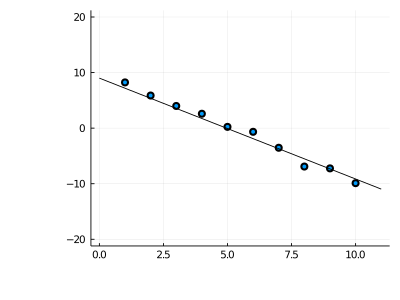

In [7]:
visualize_trace(tr, xs, observations, "MAP")

## Variational inference

Our variational distribution to approximate the posterior `approx`

In [8]:
@gen function approx(xs::Vector{Float64})
    # parametrize the marginal of :slope
    @param slope_mu::Float64
    @param slope_log_std::Float64
    # parametrize the marginal of :intercept
    @param intercept_mu::Float64
    @param intercept_log_std::Float64
    # make the relevant random choices with these variational distributions
    slope = @trace(normal(slope_mu, exp(slope_log_std)), :slope)
    intercept = @trace(normal(intercept_mu, exp(intercept_log_std)), :intercept)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##approx#296", Bool[0], false)

Initialize the trainable parameters and then perform black box variational inference ... 

Notice the use of 100 times more resources than the MAP optimization procedure. For each step, we draw 100 samples from `approx` to estimate the gradient of the variational distribution relative to log score.

Play around with these choices. 

In [28]:
function variational_inference(xs, observations)
    # initialize variational params
    init_param!(approx, :slope_mu, 0.)
    init_param!(approx, :slope_log_std, 0.)
    init_param!(approx, :intercept_mu, 0.)
    init_param!(approx, :intercept_log_std, 0.)
    # get an optimizer
    update = ParamUpdate(GradientDescent(1e-3, 100000), approx)
    # variational inference!
    (elbo_estimate, traces, elbo_history) = 
        black_box_vi!(model, (xs,), observations, approx, (xs,), update;
        iters=1000, samples_per_iter=100, verbose=true)
    return elbo_history
end

variational_inference (generic function with 1 method)

iter 1; est objective: -320.163660394374
iter 2; est objective: -303.1998366457009
iter 3; est objective: -273.03283454936087
iter 4; est objective: -164.99821465796472
iter 5; est objective: -161.4590542779411
iter 6; est objective: -163.46038364297522
iter 7; est objective: -142.38185260213936
iter 8; est objective: -145.30263912213854
iter 9; est objective: -153.4969712994436
iter 10; est objective: -140.3550422674614
iter 11; est objective: -141.16311222324538
iter 12; est objective: -134.565192839441
iter 13; est objective: -139.69869341076253
iter 14; est objective: -139.46756266333017
iter 15; est objective: -137.30117942689424
iter 16; est objective: -143.28850987104852
iter 17; est objective: -129.3381205372644
iter 18; est objective: -132.89610373002995
iter 19; est objective: -134.27191838412162
iter 20; est objective: -135.63549847409874
iter 21; est objective: -132.45628189405195
iter 22; est objective: -131.86341415103888
iter 23; est objective: -128.89997114582644
iter 2

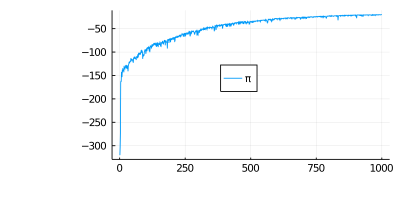

In [29]:
elbo_history = variational_inference(xs, observations)
plot(elbo_history, labels="π", thickness_scaling=3.5, size=(1600, 800), legend=:inside)

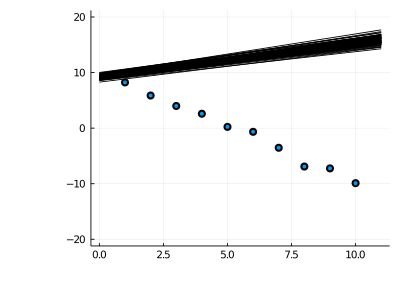

In [44]:
traces = []
for i=1:100
    tr = Gen.simulate(approx, (xs,))
    push!(traces, tr)
end
visualize_trace(traces, xs, observations, "MAP")

###  Simulated data examples

In [62]:
tr = Gen.simulate(model, (xs, ))
get_choices(tr)
observations_sim = Gen.choicemap()
[observations_sim[:y=>i] = tr[:y=>i] for i in 1:length(xs)]
ys = []
[push!(ys, observations_sim[:y=>i]) for i in 1:length(xs)]
elbo_history = variational_inference(xs, observations_sim)

iter 1; est objective: -245.38376506103873
iter 2; est objective: -142.69300245250656
iter 3; est objective: -131.6546908048431
iter 4; est objective: -74.00926050015207
iter 5; est objective: -63.95896825534401
iter 6; est objective: -66.11926551415067
iter 7; est objective: -59.07785893445334
iter 8; est objective: -55.49795720559431
iter 9; est objective: -56.29895066617675
iter 10; est objective: -51.84484592645077
iter 11; est objective: -54.238325218498495
iter 12; est objective: -52.57202720768525
iter 13; est objective: -49.50128640586662
iter 14; est objective: -49.80691685666006
iter 15; est objective: -49.51689074279923
iter 16; est objective: -39.288335498463496
iter 17; est objective: -45.23477802818113
iter 18; est objective: -40.03207239267962
iter 19; est objective: -41.91995781430647
iter 20; est objective: -39.98001389950625
iter 21; est objective: -46.4041179776159
iter 22; est objective: -42.76107453328554
iter 23; est objective: -43.4113498578918
iter 24; est objec

1000-element Vector{Float64}:
 -245.38376506103873
 -142.69300245250656
 -131.6546908048431
  -74.00926050015207
  -63.95896825534401
  -66.11926551415067
  -59.07785893445334
  -55.49795720559431
  -56.29895066617675
  -51.84484592645077
  -54.238325218498495
  -52.57202720768525
  -49.50128640586662
    ⋮
  -22.868713769081488
  -22.268476511106723
  -22.221384211491998
  -21.729014603589604
  -21.584741853414855
  -21.778850905270073
  -22.113754077628094
  -22.658271455308174
  -22.323710961928118
  -21.77655819780248
  -21.927310827873
  -21.603913726319817

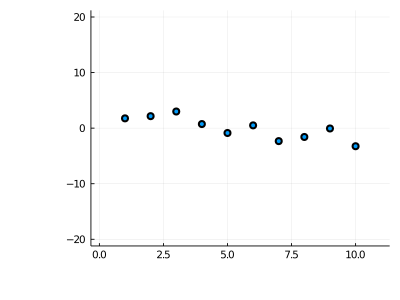

In [63]:
scatter(xs, ys, xlims=[0, 11], ylims=[-20, 20], label=nothing, thickness_scaling=3.5, size=(1600, 1200))

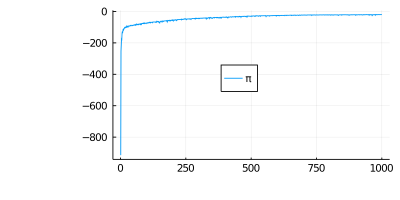

In [56]:
plot(elbo_history, labels="π", thickness_scaling=3.5, size=(1600, 800), legend=:inside)

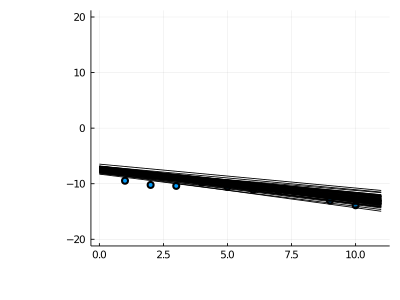

In [57]:
traces = []
for i=1:100
    tr = Gen.simulate(approx, (xs,))
    push!(traces, tr)
end
visualize_trace(traces, xs, observations_sim, "MAP")

## MLE -- a single estimate

In [13]:
@gen function model_trainable(xs::Vector{Float64})
    @param slope::Float64
    @param intercept::Float64
    for (i, x) in enumerate(xs)
        {:y=>i} ~ normal(slope * x + intercept, 1)
    end
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##model_trainable#298", Bool[0], false)

In [14]:
init_param!(model_trainable, :slope, 0.)
init_param!(model_trainable, :intercept, 0.)
loss = []
update = ParamUpdate(GradientDescent(1e-3, 100000), model_trainable)

for iter=1:1000
    trace, _ = Gen.generate(model_trainable, (xs,), observations)
    objective = get_score(trace) 
    push!(loss, objective)
    accumulate_param_gradients!(trace)
    apply!(update)
end
loss

1000-element Vector{Any}:
 -177.16093533204673
 -143.36726840854675
 -130.61307199048056
 -125.6145358999599
 -123.47575015697745
 -122.39224084845641
 -121.69892539273148
 -121.15066502199988
 -120.65710106928947
 -120.18492344104294
 -119.72184919104528
 -119.26334574097142
 -118.80773726080383
    ⋮
  -12.603443565568522
  -12.595876593994923
  -12.588341131152305
  -12.580837045528531
  -12.573364206161651
  -12.56592248263762
  -12.55851174508797
  -12.551131864187589
  -12.54378271115236
  -12.536464157736951
  -12.529176076232531
  -12.521918339464516

In [15]:
get_param(model_trainable, :slope)

-1.8093996159585422

In [16]:
get_param(model_trainable, :intercept)

8.951679966491481